In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the words
words = open('repo\\names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build vocabulary of characters and mapping to/from integers (indexing in an out)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
# build dataset (example)

block_size = 3 # context lenght: how many characters do we take to predict the next one
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [ ]:
# build dataset
block_size = 3
X, Y = [], []
for w in words:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [27]:
# build the lookup table
C = torch.randn((27,2))
embs = C[X]
embs.shape

torch.Size([32, 3, 2])

In [44]:
# build the weights and bias (initialized randomly then modify by training)
W1 = torch.randn((6,100)) # 3*2 because 2 dimensiannal embeding and 3. number of neurons is up to us so let's use 100 as example
b1 = torch.randn(100)

In [ ]:
# we want to do embs @ W1 + b1 but the dimensions does not allow us to do that.
# torch is a large library that has a lot of functions. one of them allow to concatenate
torch.cat((embs[:, 0, :], embs[:, 1, :], embs[:, 2, :]), 1) # however this is ugly because if we used a block != than 3 in size, we would need to add another embs[:, 3, :] and so on which doesn't make it great
# so we use torch.unbind which remove a tensor dimension and return a tuple of all slice along a given dimension
torch.cat(torch.unbind(embs, 1), 1).shape
# but there is a better way.
embs.view(32, 6)
# here to prove it
embs.view(32,6) == torch.cat(torch.unbind(embs, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [60]:
h = torch.tanh(embs.view(embs.shape[0], 6) @ W1 + b1) # rather than embs.shape[0], we could use -1 to let torch guess which size is needed
h.shape

torch.Size([32, 100])

In [61]:
# build the second weights and bias
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [66]:
logits = h @ W2 + b2

In [67]:
logits.shape

torch.Size([32, 27])

In [68]:
counts = logits.exp()

In [72]:
probs = counts / counts.sum(1, keepdim=True)
probs[0].sum()

tensor(1.0000)

In [78]:
# now we would like to index into the rows of probs and each row we would like to pluck out the probability assigned to the correct character.
predicted_prob = probs[torch.arange(32), Y]
# now transform this into the loss function
loss = -predicted_prob.log().mean()
loss

tensor(19.7475)

# Rewritting for clarity

In [80]:
# dataset
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [169]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # so we can count them

In [170]:
sum(p.nelement() for p in parameters) # numbers of total parameters

3481

In [171]:
# forward pass (classification)
# Model outputs: emb → h → logits (these are the network forward outputs).
# Post‑processing: counts = logits.exp(); prob = counts / counts.sum(1, keepdim=True) (softmax via exp+norm).
# Loss: loss = -prob[torch.arange(32), Y].log().mean() (still part of the forward pass; it turns outputs into a scalar used for backprop).
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [172]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# faster classification using torch <= cross_entrepy is better: doesn't create all the intermediary tensors in memory.
for i in range(100):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())
# the ony reason this is so straightforward right now is because we only have 32 examples for the first 5 words and 3481 parameters. X.shape => [32, 3]). So we are overfitting as single small batch of examples.

# the reason why we cannot seems to get to 0; compare indice of logits.max(1) to Y. Both are very close but with some differences
print(f'\nIndices of max of the first dimension:\n {logits.max(1).indices}\n')
print(f'Labels:\n {Y}')
# fundamentally, the reason is because we have [...] predicting [e] for ...emma. but we also have [...] predicting [o] for ...olivia and so on for following names.
# Overfitting would mean unique input => unique output always and in this case, it is impossible since some examples give different inputs for the same output.

0.2538580000400543

Indices of max of the first dimension:
 tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Labels:
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


# Now we redo for the whole dataset

In [284]:
# read all the words
words = open('repo\\names.txt', 'r').read().splitlines()
words[:8]

# build vocabulary of characters and mapping to/from integers (indexing in an out)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# build dataset
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# initialize weights and bias
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# require gradients
for p in parameters:
    p.requires_grad = True

# training
# for i in range(10):
#     # forward pass
#     emb = C[X]
#     h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
#     logits = h @ W2 + b2
#     loss = F.cross_entropy(logits, Y)
#     print(loss.item())
#     # backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()
#     # update
#     for p in parameters:
#         p.data += -0.1 * p.grad



In [285]:
# now in practice, people do not train on all the data set at once (were talking about millions, billions and trillions parameters)
# so we want to randomly select some mini batches to train on them
torch.randint(0, X.shape[0], [32,])

tensor([142342,  70632, 127190, 162072,  57024,  43742,  92492, 117551, 114336,
        148361, 112497,  11573, 123696,     18, 129976, 129722, 136838, 204458,
        177478, 137203, 215213,  76298,  68624, 149910, 181756, 120994,  45794,
         14433, 190377, 137303,  27186, 134840])

In [ ]:
# actual training 
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # <= only taking part of the dataset
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # <= also modified to only act on the minibatch
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())
# because we don't work on all of the dataset, the quality of the gradient is lower but the direction is good enough to be useful.

2.5121853351593018


In [286]:
# now let's evaluate the total loss to have an idea of the impact of our training (if using the video data, you should get a strating loss of 19.505)
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

19.505229949951172

One question that is coming to mind is "__Are we stepping too slow or too fast with the 0.1 ?__"
The response is testing, first with very low number then we slowly try to find a number were the change are clear. After that, we find a number were is explose and we slowly lower it. Then we get he two "max" and "min" and we try to find a middle ground.

In [272]:
# we create an evolutive learning rates
learning_rate_exp = torch.linspace(-3, 0, 1000) 
lrs = 10**learning_rate_exp
lrs # learning rate between 0.001 to 1 but exponentialy stepped.

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [274]:
# training on minibatches with a growing learning rate
lri = [] # tracking learning rate used
lossi= [] # tracking loss evolution

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i] # <= get the learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(learning_rate_exp[i])
    lossi.append(loss.item())

loss.item()

7.184268474578857

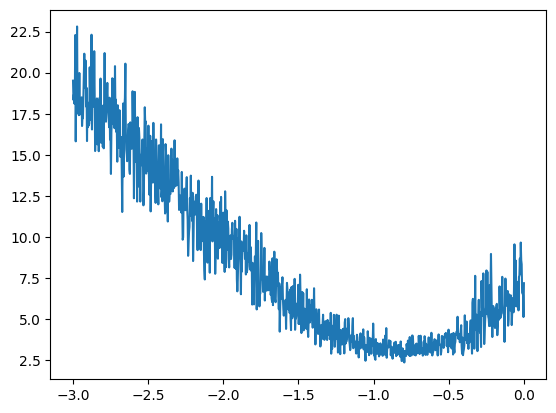

In [ ]:
plt.plot(lri, lossi)
# we can see that at first the exponent of the learning barely impact the model result then between -1.5 to -0.5 it stabilize. Then after -0.5, the result becomes eratic.
# And that's how you determine the learning rate you want for your training.

In [291]:
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01 # <= 0.1 evaluated as a good learning rate. After some runs, we decay the learning rate maybe to 0.01. In actual production, you would not change the learning rate by hand by maybe every x training, you would lower it by *10 maybe.
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(learning_rate_exp[i])
    # lossi.append(loss.item())

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3393, grad_fn=<NllLossBackward0>)

# We separate the dataset into training, evaluation and testing splits

In [303]:
# read all the words
words = open('repo\\names.txt', 'r').read().splitlines()
words[:8]

# build vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

def build_dataset(words):
    # build dataset
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [304]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [305]:
for p in parameters:
  p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i%10000 == 0:
        print(loss.item())



25.13323974609375
2.355954647064209
2.2842533588409424
2.179556369781494
2.4732038974761963
2.4020495414733887
2.517728328704834
2.1528310775756836
1.9792683124542236
1.9294264316558838
2.377570390701294
1.9090368747711182
2.104092597961426
1.8971571922302246
2.158618927001953
2.153169870376587
1.7773082256317139
2.107419013977051
2.3152337074279785
1.8040602207183838


RuntimeError: mat1 and mat2 shapes cannot be multiplied (913125x6 and 30x200)

tensor(2.1142, grad_fn=<NllLossBackward0>)
tensor(2.1582, grad_fn=<NllLossBackward0>)


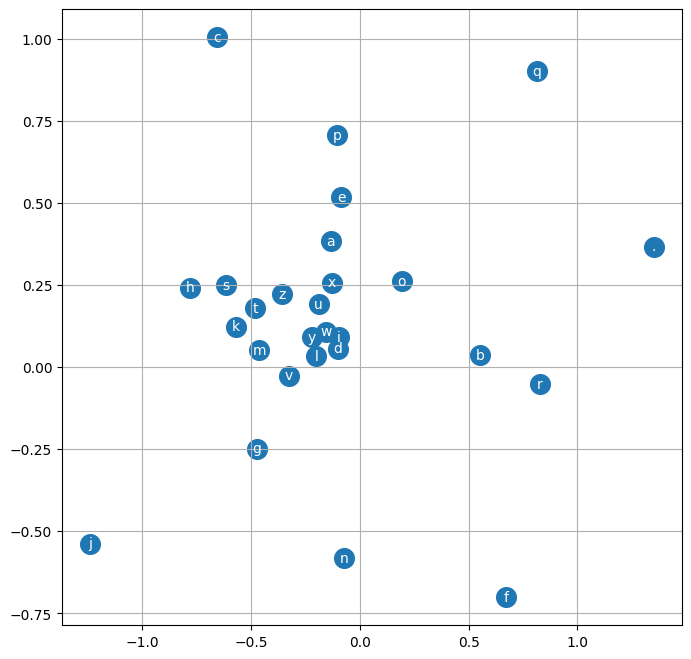

In [307]:
# training model loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss)

# evaluation model loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss)


# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Now we use the model to generate names

In [310]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1]))

carmahzato
hariffinleige
tylenanden
jazhnen
deliah
jageni
nellara
chaiivia
legynd
bman
